## SF-crime Kaggle competition

In [1]:
# Let's start by some standard code
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *
from fastai.column_data import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from IPython.display import display

from sklearn import metrics
from graphviz import *

In [3]:
PATH = "data/sf-crime/"

In [4]:
!ls {PATH}

common_cats_data     results_m3_sub.csv   results_m7.csv
models               results_m4.csv       results_m7_sub.csv
old_results          results_m4_sub.csv   sampleSubmission.csv
results_m1.csv       results_m5.csv       test.csv
results_m1_sub.csv   results_m5_sub.csv   tmp
results_m2.csv       results_m6.csv       train.csv
results_m3.csv       results_m6_sub.csv


### 1. Let's load and explore the data

In [232]:
train=pd.read_csv(f'{PATH}train.csv',parse_dates=['Dates'])

In [233]:
train.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

In [234]:
display(train.head())

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [235]:
display(train.isnull().sum().sort_index()/len(train))

Address       0.0
Category      0.0
Dates         0.0
DayOfWeek     0.0
Descript      0.0
PdDistrict    0.0
Resolution    0.0
X             0.0
Y             0.0
dtype: float64

### What we see in the data
1. One date field. So the date formatting and feature extraction is required.
2. A few categorical variables. We will have to convert these into numbers.
3. No missing values.

### Let's explore the response variable (y)

In [236]:
train['Category'].unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT', 'VANDALISM', 'NON-CRIMINAL',
       'ROBBERY', 'ASSAULT', 'WEAPON LAWS', 'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY', 'SECONDARY CODES', 'TRESPASS',
       'MISSING PERSON', 'FRAUD', 'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT', 'ARSON', 'FAMILY OFFENSES',
       'LIQUOR LAWS', 'BRIBERY', 'EMBEZZLEMENT', 'SUICIDE', 'LOITERING', 'SEX OFFENSES NON FORCIBLE',
       'EXTORTION', 'GAMBLING', 'BAD CHECKS', 'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [237]:
train.groupby('Category').count().sort_values('Dates')

,Dates,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
Category,,,,,,,,
TREA,6,6,6,6,6,6,6,6
PORNOGRAPHY/OBSCENE MAT,22,22,22,22,22,22,22,22
GAMBLING,146,146,146,146,146,146,146,146
SEX OFFENSES NON FORCIBLE,148,148,148,148,148,148,148,148
EXTORTION,256,256,256,256,256,256,256,256
BRIBERY,289,289,289,289,289,289,289,289
BAD CHECKS,406,406,406,406,406,406,406,406
FAMILY OFFENSES,491,491,491,491,491,491,491,491
SUICIDE,508,508,508,508,508,508,508,508


In [238]:
# The 0.1% of the data would be:
len(train)*0.001

878.049

In [239]:
train.groupby('Category').count().sort_values('Dates').head(10)

,Dates,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
Category,,,,,,,,
TREA,6,6,6,6,6,6,6,6
PORNOGRAPHY/OBSCENE MAT,22,22,22,22,22,22,22,22
GAMBLING,146,146,146,146,146,146,146,146
SEX OFFENSES NON FORCIBLE,148,148,148,148,148,148,148,148
EXTORTION,256,256,256,256,256,256,256,256
BRIBERY,289,289,289,289,289,289,289,289
BAD CHECKS,406,406,406,406,406,406,406,406
FAMILY OFFENSES,491,491,491,491,491,491,491,491
SUICIDE,508,508,508,508,508,508,508,508


In [240]:
len(train["Category"].unique())

39

### 2. Load Test data

In [241]:
test = pd.read_csv(f'{PATH}test.csv',date_parser='Dates')

In [242]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


### 3. Merge the data

In [243]:
train.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

In [244]:
test.columns

Index(['Id', 'Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y'], dtype='object')

In [245]:
# Let's remove extra columns
train.drop(['Descript','Resolution'],axis=1,inplace=True)
test.drop(['Id'],axis=1,inplace=True)
# Add dummy column in test dataset, which we will remove later
test['Category']='TREA'
# Add dataset identifier
train['is_train'] = 1
test['is_train'] = 0

In [246]:
train.columns

Index(['Dates', 'Category', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y',
       'is_train'],
      dtype='object')

In [247]:
test.columns

Index(['Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'Category',
       'is_train'],
      dtype='object')

In [248]:
df_master = pd.concat([train,test],axis=0,sort=True,ignore_index=True)

In [249]:
df_master.head()

,Address,Category,Dates,DayOfWeek,PdDistrict,X,Y,is_train
0,OAK ST / LAGUNA ST,WARRANTS,2015-05-13 23:53:00,Wednesday,NORTHERN,-122.425892,37.774599,1
1,OAK ST / LAGUNA ST,OTHER OFFENSES,2015-05-13 23:53:00,Wednesday,NORTHERN,-122.425892,37.774599,1
2,VANNESS AV / GREENWICH ST,OTHER OFFENSES,2015-05-13 23:33:00,Wednesday,NORTHERN,-122.424363,37.800414,1
3,1500 Block of LOMBARD ST,LARCENY/THEFT,2015-05-13 23:30:00,Wednesday,NORTHERN,-122.426995,37.800873,1
4,100 Block of BRODERICK ST,LARCENY/THEFT,2015-05-13 23:30:00,Wednesday,PARK,-122.438738,37.771541,1


In [250]:
df_master.tail()

,Address,Category,Dates,DayOfWeek,PdDistrict,X,Y,is_train
1762306,2600 Block of BRYANT ST,TREA,2003-01-01 00:01:00,Wednesday,MISSION,-122.408983,37.751987,0
1762307,1900 Block of WASHINGTON ST,TREA,2003-01-01 00:01:00,Wednesday,NORTHERN,-122.425342,37.792681,0
1762308,5500 Block of MISSION ST,TREA,2003-01-01 00:01:00,Wednesday,INGLESIDE,-122.445418,37.712075,0
1762309,1500 Block of HUDSON AV,TREA,2003-01-01 00:01:00,Wednesday,BAYVIEW,-122.387394,37.739479,0
1762310,1500 Block of SLOAT BL,TREA,2003-01-01 00:01:00,Wednesday,TARAVAL,-122.489714,37.733950,0


In [251]:
len(train), len(test), len(df_master)

(878049, 884262, 1762311)

### 4. Feature Engineering

In [252]:
df_master.columns

Index(['Address', 'Category', 'Dates', 'DayOfWeek', 'PdDistrict', 'X', 'Y',
       'is_train'],
      dtype='object')

#### Add data-time features

In [253]:
Dates = df_master['Dates']
add_datepart(df=df_master,fldname='Dates',time=True)

In [254]:
df_master.columns

Index(['Address', 'Category', 'DayOfWeek', 'PdDistrict', 'X', 'Y', 'is_train',
       'DatesYear', 'DatesMonth', 'DatesWeek', 'DatesDay', 'DatesDayofweek',
       'DatesDayofyear', 'DatesIs_month_end', 'DatesIs_month_start',
       'DatesIs_quarter_end', 'DatesIs_quarter_start', 'DatesIs_year_end',
       'DatesIs_year_start', 'DatesHour', 'DatesMinute', 'DatesSecond',
       'DatesElapsed'],
      dtype='object')

In [255]:
df_master['YearMonth']= df_master['DatesYear'].map(str)  + df_master['DatesMonth'].map(str) 
df_master['Dates']= Dates

In [256]:
df_master[['DayOfWeek','DatesDayofweek']].head()

,DayOfWeek,DatesDayofweek
0,Wednesday,2
1,Wednesday,2
2,Wednesday,2
3,Wednesday,2
4,Wednesday,2


In [257]:
df_master.drop(['DayOfWeek'],axis=1,inplace=True)

#### Add X, Y features

In [258]:
# Lets' created scaled transform of the X and Y coordinates
xy_scaler = StandardScaler()
xy_scaler.fit(df_master.loc[:,['X','Y']])
xy_scaled = xy_scaler.transform(df_master.loc[:,['X','Y']])

# PCA on X and Y, select top 2 components
xy_pca = PCA(n_components=2, whiten=True).fit_transform(xy_scaled)

# Rotation
rot45_X = .707* xy_scaled[:,1] + .707* xy_scaled[:,0] 
rot45_Y = .707* xy_scaled[:,1] - .707* xy_scaled[:,0]

rot30_X = (1.732/2)* xy_scaled[:,0] + (1./2)* xy_scaled[:,1]
rot30_Y = (1.732/2)* xy_scaled[:,1] - (1./2)* xy_scaled[:,0]

rot60_X = (1./2)* xy_scaled[:,0] + (1.732/2)* xy_scaled[:,1] 
rot60_Y = (1./2)* xy_scaled[:,1] - (1.732/2)* xy_scaled[:,0]

# Polar coordinates
radial_r = np.sqrt( np.power(xy_scaled[:,1],2) + np.power(xy_scaled[:,0],2) )
radial_phi = np.arctan2(xy_scaled[:,1], xy_scaled[:,0])

xy_scaled_df=pd.DataFrame(xy_scaled)
xy_pca_df=pd.DataFrame(xy_pca)

In [259]:
df_master['xy_scaled_1']    = xy_scaled_df[0]
df_master['xy_scaled_2']    = xy_scaled_df[1]
df_master['xy_pca_1']       = xy_pca_df[0]
df_master['xy_pca_2']       = xy_pca_df[1]
df_master['xy_x_rotate_30'] = rot30_X
df_master['xy_x_rotate_45'] = rot45_X
df_master['xy_x_rotate_60'] = rot60_X
df_master['xy_y_rotate_30'] = rot30_Y
df_master['xy_y_rotate_45'] = rot45_Y
df_master['xy_y_rotate_60'] = rot60_Y
df_master['xy_radial_r']    = radial_r
df_master['xy_radial_phi']  = radial_phi

#### Add Address features

In [260]:
# Create a feature for street intersection
df_master['add_contains_intersection']=df_master['Address'].str.contains('/')

# Create a feature for block or no-block in the address
add_upper=df_master['Address'].str.upper()
df_master['add_contains_block']=add_upper.str.contains('BLOCK')

# Create a feature to capture the data before and after the '/'
add_p1, add_p2 = df_master['Address'].str.split('/', 1).str

add_p1=add_p1.str.rstrip()
df_master['add_part1']=add_p1.str.lstrip()
add_p2=add_p2.str.rstrip()
df_master['add_part2']=add_p2.str.lstrip()

# Check if the split went well
df_master[['Address','add_part1','add_part2']].head(15)

,Address,add_part1,add_part2
0,OAK ST / LAGUNA ST,OAK ST,LAGUNA ST
1,OAK ST / LAGUNA ST,OAK ST,LAGUNA ST
2,VANNESS AV / GREENWICH ST,VANNESS AV,GREENWICH ST
3,1500 Block of LOMBARD ST,1500 Block of LOMBARD ST,NaN
4,100 Block of BRODERICK ST,100 Block of BRODERICK ST,NaN
5,0 Block of TEDDY AV,0 Block of TEDDY AV,NaN
6,AVALON AV / PERU AV,AVALON AV,PERU AV
7,KIRKWOOD AV / DONAHUE ST,KIRKWOOD AV,DONAHUE ST
8,600 Block of 47TH AV,600 Block of 47TH AV,NaN
9,JEFFERSON ST / LEAVENWORTH ST,JEFFERSON ST,LEAVENWORTH ST


In [261]:
# Type of the first part of address (ST, AV BL etc)
df_master['add_part1_type']=df_master['add_part1'].str[-2:]
np.unique(df_master['add_part1_type'])

array(['80', 'AL', 'AR', 'AV', 'AY', 'BL', 'CR', 'CT', 'DR', 'ER', 'EX', 'HY', 'LN', 'MS', 'NO', 'PL', 'PZ',
       'RD', 'RK', 'RW', 'ST', 'TI', 'TR', 'WK', 'WY'], dtype=object)

#### PdDistrict one-hot-encoding

In [38]:
#districts_ohe = pd.get_dummies(df_master['PdDistrict'],dtype='i',)
#districts_ohe.head(), districts_ohe.shape

In [39]:
#df_master=pd.concat([df_master, districts_ohe],axis=1)
#df_master.head()

In [40]:
#df_master.drop('PdDistrict',axis=1,inplace=True)

### 5. Format the data

In [262]:
train_n_val=pd.DataFrame(df_master[df_master.is_train==1])
test       =pd.DataFrame(df_master[df_master.is_train==0])
train_n_val.shape, test.shape, train_n_val.columns

((878049, 41),
 (884262, 41),
 Index(['Address', 'Category', 'PdDistrict', 'X', 'Y', 'is_train', 'DatesYear',
        'DatesMonth', 'DatesWeek', 'DatesDay', 'DatesDayofweek',
        'DatesDayofyear', 'DatesIs_month_end', 'DatesIs_month_start',
        'DatesIs_quarter_end', 'DatesIs_quarter_start', 'DatesIs_year_end',
        'DatesIs_year_start', 'DatesHour', 'DatesMinute', 'DatesSecond',
        'DatesElapsed', 'YearMonth', 'Dates', 'xy_scaled_1', 'xy_scaled_2',
        'xy_pca_1', 'xy_pca_2', 'xy_x_rotate_30', 'xy_x_rotate_45',
        'xy_x_rotate_60', 'xy_y_rotate_30', 'xy_y_rotate_45', 'xy_y_rotate_60',
        'xy_radial_r', 'xy_radial_phi', 'add_contains_intersection',
        'add_contains_block', 'add_part1', 'add_part2', 'add_part1_type'],
       dtype='object'))

In [263]:
cat_vars = ['Address','PdDistrict','DatesYear','DatesMonth','DatesWeek','DatesDayofweek','DatesDayofyear',
            'DatesIs_month_end','DatesIs_month_start','DatesIs_quarter_end','DatesIs_quarter_start',
            'DatesIs_year_end','DatesIs_year_start','DatesHour','DatesMinute','DatesSecond','DatesElapsed',
            'YearMonth', 'add_contains_intersection', 'add_contains_block','add_part1', 'add_part2', 'add_part1_type']
contin_vars = ['X','Y','xy_scaled_1','xy_scaled_2','xy_pca_1','xy_pca_2','xy_x_rotate_30','xy_x_rotate_45',
               'xy_x_rotate_60','xy_y_rotate_30','xy_y_rotate_45','xy_y_rotate_60','xy_radial_r','xy_radial_phi']

In [264]:
dep='Category'
train_n_val = train_n_val[cat_vars+contin_vars+[dep, 'Dates']].copy()

In [265]:
test[dep] = 0
test = test[cat_vars+contin_vars+[dep, 'Dates']].copy()

In [280]:
for v in cat_vars: train_n_val[v] = train_n_val[v].astype('category').cat.as_ordered()
for v in [dep]: train_n_val[v] = train_n_val[v].astype('category').cat.as_ordered()
for v in cat_vars: test[v] = test[v].astype('category').cat.as_ordered()

In [269]:
apply_cats(train_n_val, test)

In [270]:
for v in contin_vars:
    train_n_val[v] = train_n_val[v].astype('float32')
    test[v] = test[v].astype('float32')

In [323]:
n = len(train_n_val)
idxs = get_cv_idxs(n, val_pct=150000/n)
train_n_val_samp = train_n_val.iloc[idxs].set_index("Dates")
samp_size = len(train_n_val_samp)
train_n_val_samp=samp_size; train_n_val_samp

150000

To run on the full dataset, use this instead:

In [271]:
samp_size = n
train_n_val_samp = train_n_val.set_index("Dates")

In [272]:
train_n_val_samp.head(2)

,Address,PdDistrict,DatesYear,DatesMonth,DatesWeek,DatesDayofweek,DatesDayofyear,DatesIs_month_end,DatesIs_month_start,DatesIs_quarter_end,...,xy_pca_2,xy_x_rotate_30,xy_x_rotate_45,xy_x_rotate_60,xy_y_rotate_30,xy_y_rotate_45,xy_y_rotate_60,xy_radial_r,xy_radial_phi,Category
Dates,,,,,,,,,,,,,,,,,,,,,
2015-05-13 23:53:00,OAK ST / LAGUNA ST,NORTHERN,2015,5,20,2,133,False,False,False,...,0.121525,-0.087831,-0.06958,-0.046606,0.058921,0.079634,0.094941,0.105766,3.074315,WARRANTS
2015-05-13 23:53:00,OAK ST / LAGUNA ST,NORTHERN,2015,5,20,2,133,False,False,False,...,0.121525,-0.087831,-0.06958,-0.046606,0.058921,0.079634,0.094941,0.105766,3.074315,OTHER OFFENSES


In [273]:
train_n_val_samp.dtypes

Address                      category
PdDistrict                   category
DatesYear                    category
DatesMonth                   category
DatesWeek                    category
DatesDayofweek               category
DatesDayofyear               category
DatesIs_month_end            category
DatesIs_month_start          category
DatesIs_quarter_end          category
DatesIs_quarter_start        category
DatesIs_year_end             category
DatesIs_year_start           category
DatesHour                    category
DatesMinute                  category
DatesSecond                  category
DatesElapsed                 category
YearMonth                    category
add_contains_intersection    category
add_contains_block           category
add_part1                    category
add_part2                    category
add_part1_type               category
X                             float32
Y                             float32
xy_scaled_1                   float32
xy_scaled_2 

In [324]:
df, y, nas, mapper = proc_df(train_n_val_samp, 'Category', do_scale=True)
yl = np.log(y)

AttributeError: 'int' object has no attribute 'loc'

In [277]:
test = test.set_index("Dates")

In [281]:
test.dtypes

Address                      category
PdDistrict                   category
DatesYear                    category
DatesMonth                   category
DatesWeek                    category
DatesDayofweek               category
DatesDayofyear               category
DatesIs_month_end            category
DatesIs_month_start          category
DatesIs_quarter_end          category
DatesIs_quarter_start        category
DatesIs_year_end             category
DatesIs_year_start           category
DatesHour                    category
DatesMinute                  category
DatesSecond                  category
DatesElapsed                 category
YearMonth                    category
add_contains_intersection    category
add_contains_block           category
add_part1                    category
add_part2                    category
add_part1_type               category
X                             float32
Y                             float32
xy_scaled_1                   float32
xy_scaled_2 

In [282]:
df_test, _, nas, mapper = proc_df(test, 'Category', do_scale=True, mapper=mapper, na_dict=nas)

In [283]:
val_idx = np.random.randint(low=1,high=878048,size=78049,dtype='i')
len(val_idx),val_idx[50:70]

(78049,
 array([602306,   5883,  77934, 476362, 569756,  38180, 809334,   2530, 789438, 143724, 488372, 532982,
        376666,  96580, 459738, 328065, 172128, 107941, 866471,  97761], dtype=int32))

1 - List the categorical and continuous variables.<br>
2 - Create val_idx<br>
3 - Create model data by called ColumnarData.from_data_frame with arguments PATH (to the outputing model details), df, y, val_idx, <br>
(scale somewhere along the way)<br>
4 - Define the dimensions of embedding matrices for each categorical variable <br>
5 - Call learner <br>
6 - Call m.fit <br>

In [285]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [309]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128)

In [310]:
cat_sz = [(c, len(train_n_val_samp[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('Address', 23229),
 ('PdDistrict', 11),
 ('DatesYear', 14),
 ('DatesMonth', 13),
 ('DatesWeek', 27),
 ('DatesDayofweek', 8),
 ('DatesDayofyear', 339),
 ('DatesIs_month_end', 3),
 ('DatesIs_month_start', 3),
 ('DatesIs_quarter_end', 3),
 ('DatesIs_quarter_start', 3),
 ('DatesIs_year_end', 3),
 ('DatesIs_year_start', 3),
 ('DatesHour', 25),
 ('DatesMinute', 61),
 ('DatesSecond', 2),
 ('DatesElapsed', 389258),
 ('YearMonth', 150),
 ('add_contains_intersection', 3),
 ('add_contains_block', 3),
 ('add_part1', 12553),
 ('add_part2', 1695),
 ('add_part1_type', 26)]

In [311]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(23229, 50),
 (11, 6),
 (14, 7),
 (13, 7),
 (27, 14),
 (8, 4),
 (339, 50),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (25, 13),
 (61, 31),
 (2, 1),
 (389258, 50),
 (150, 50),
 (3, 2),
 (3, 2),
 (12553, 50),
 (1695, 50),
 (26, 13)]

In [312]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [320]:
lr = 1e-2

In [321]:
m.lr_find()

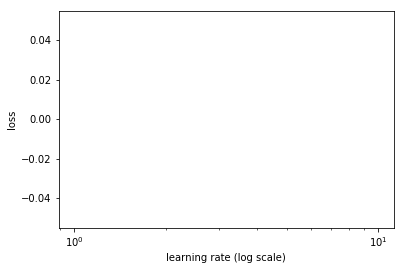

In [317]:
m.sched.plot(100)

In [322]:
m.fit(lr, 3, metrics=[exp_rmspe])

  4%|▍         | 257/6277 [01:13<28:32,  3.51it/s, loss=nan]

KeyboardInterrupt: 

In [51]:
# Creating training and validation dataset from train
train_x = train_and_val_x.drop(train_and_val_x.index[val_idx], inplace=False)
val_x   = train_and_val_x.iloc[val_idx,]
train_y = np.delete(train_and_val_y, val_idx)
val_y   = train_and_val_y[val_idx]

train_train = train.drop(train.index[val_idx], inplace=False) # Contains y
train_val   = train.iloc[val_idx,] # Contains y

train_train.shape, train_x.shape, train_val.shape, val_x.shape, len(train_y), len(val_y)

((803492, 8), (803492, 49), (78000, 8), (78000, 49), 803492, 78000)

In [52]:
train_x.tail()

,Address,DayOfWeek,X,Y,is_train,DatesYear,DatesMonth,DatesWeek,DatesDay,DatesDayofweek,...,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
878044,16537,2,-122.459033,37.714056,1,2003,1,2,6,0,...,0,0,0,0,0,0,0,0,1,0
878045,11841,2,-122.447364,37.731948,1,2003,1,2,6,0,...,0,0,1,0,0,0,0,0,0,0
878046,11663,2,-122.403390,37.780266,1,2003,1,2,6,0,...,0,0,0,0,0,0,0,1,0,0
878047,23739,2,-122.390531,37.780607,1,2003,1,2,6,0,...,0,0,0,0,0,0,0,1,0,0
878048,5301,2,-122.394926,37.738212,1,2003,1,2,6,0,...,1,0,0,0,0,0,0,0,0,0


In [53]:
train_y[1:50], np.unique(train_y), val_y[1:50], np.unique(val_y)

(array([21, 21, 16, 16, 36, 36, 16, 16, 16, 35, 20, 20, 25,  1, 21, 20, 16, 25, 37, 20, 16, 20, 16, 16, 21,
        16, 35, 16, 16, 16, 16, 35, 20, 16, 16, 21, 36, 20,  4, 16, 16, 32, 16, 16, 16, 36, 36,  8, 32],
       dtype=int8),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38], dtype=int8),
 array([21, 23, 21, 16, 21,  4, 21, 13, 16, 16, 16, 21, 37,  7, 16, 16,  1, 35, 24, 25, 35,  7, 36, 21, 16,
        20,  7, 37, 13, 16, 20, 20, 36, 21, 16, 35,  4, 21, 13, 19, 36, 16, 35, 16, 16, 20, 21, 36, 21],
       dtype=int8),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38], dtype=int8))

In [54]:
test_x = pd.DataFrame(x_all[x_all['is_train']==0])
test_x.shape

(884262, 49)

In [55]:
test_x.tail()

,Address,DayOfWeek,X,Y,is_train,DatesYear,DatesMonth,DatesWeek,DatesDay,DatesDayofweek,...,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
1762306,7920,7,-122.408983,37.751987,0,2003,1,1,1,2,...,0,0,0,1,0,0,0,0,0,0
1762307,5597,7,-122.425342,37.792681,0,2003,1,1,1,2,...,0,0,0,0,1,0,0,0,0,0
1762308,11613,7,-122.445418,37.712075,0,2003,1,1,1,2,...,0,0,1,0,0,0,0,0,0,0
1762309,4394,7,-122.387394,37.739479,0,2003,1,1,1,2,...,1,0,0,0,0,0,0,0,0,0
1762310,4477,7,-122.489714,37.733950,0,2003,1,1,1,2,...,0,0,0,0,0,0,0,0,1,0


### 6. Building the models

In [164]:
# Base model of 30 trees
m = RandomForestClassifier(n_jobs=-1,n_estimators=30)
m.fit(train_x, train_y)
m.score(train_x, train_y)

0.8574373411962203

In [165]:
# Adding max_features (columns)
m2 = RandomForestClassifier(n_jobs=-1,n_estimators=30,max_features=0.6)
m2.fit(train_x, train_y)
m2.score(train_x, train_y)

0.8574441745278453

In [57]:
rare_cats = set(['SUICIDE','FAMILY OFFENSES', 'BAD CHECKS', 'BRIBERY', 'EXTORTION',
       'SEX OFFENSES NON FORCIBLE', 'GAMBLING', 'PORNOGRAPHY/OBSCENE MAT',
       'TREA'])
all_cats = set(train['Category'].unique())
common_cats = all_cats-rare_cats
# Create index of common Categories
train_common_cat_idx = train_train['Category'].isin(common_cats)
val_common_cat_idx   = train_val['Category'].isin(common_cats)
# subset train data
train_x_common_cats = train_x[train_common_cat_idx]
train_y_common_cats = train_y[train_common_cat_idx]
val_x_common_cats   = val_x[val_common_cat_idx]
val_y_common_cats   = val_y[val_common_cat_idx]

len(train_x_common_cats), len(train_y_common_cats), len(val_x_common_cats), len(val_y_common_cats)

(801412, 801412, 77797, 77797)

In [58]:
del train_train
del train_val
del df_master
del train

In [167]:
# Using common features only
m3 = RandomForestClassifier(n_jobs=-1,n_estimators=30)
m3.fit(train_x_common_cats, train_y_common_cats)
m3.score(train_x_common_cats, train_y_common_cats)

0.8583520690769454

In [168]:
# Using common features only and min_samples (tree stops when # examples equals to)
m4 = RandomForestClassifier(n_jobs=-1,n_estimators=30, min_samples_leaf=3)
m4.fit(train_x_common_cats, train_y_common_cats)
m4.score(train_x_common_cats, train_y_common_cats)

0.7442762255688378

In [169]:
# Using common features only and max_feature (max percent of columns in any given tree)
m5 = RandomForestClassifier(n_jobs=-1,n_estimators=30, max_features=0.5)
m5.fit(train_x_common_cats, train_y_common_cats)
m5.score(train_x_common_cats, train_y_common_cats)

0.8583178137813622

In [59]:
# Using common features only and max_feature (max percent of columns in any given tree)
m6 = RandomForestClassifier(n_jobs=-1,n_estimators=512, max_features=0.5, min_samples_leaf=3)
m6.fit(train_x_common_cats, train_y_common_cats)
m6.score(train_x_common_cats, train_y_common_cats), m6.score(val_x_common_cats, val_y_common_cats)

(0.8166261548367132, 0.3447562245330797)

### 7. Testing the models

In [171]:
results_m1 = m.predict(test_x)

In [175]:
results_m2 = m2.predict(test_x)

In [176]:
results_m3 = m3.predict(test_x)

In [177]:
results_m4 = m4.predict(test_x)

In [178]:
results_m5 = m5.predict(test_x)

In [179]:
results_m6 = m6.predict(test_x)

### 8. Writing the Output

In [172]:
def write_results(results,file_name):
    
    result_accumulator=list()
    print("Step 1: one-hot-encoding...")

    for i in range(0,len(results)):
        temp=np.zeros(39,dtype=int)
        temp[results[i]]=1
        line=np.insert(temp,0,i)
        result_accumulator.append(line)

    print("Step 2: Formatting into dataframe...")    

    out_file = pd.DataFrame(result_accumulator)
    print("Dimension of the output file: ",out_file.shape)

    print("Step 3: Writing the output file...") 
    out_file_address = 'data/sf-crime/' + file_name + '.csv'
    out_file.to_csv(out_file_address,index=False)

In [173]:
write_results(results_m1,'results_m1')

Step 1: one-hot-encoding...
Step 2: Formatting into dataframe...
Dimension of the output file:  (884262, 40)
Step 3: Writing the output file...


In [180]:
write_results(results_m2,'results_m2')

Step 1: one-hot-encoding...
Step 2: Formatting into dataframe...
Dimension of the output file:  (884262, 40)
Step 3: Writing the output file...


In [181]:
write_results(results_m3,'results_m3')

Step 1: one-hot-encoding...
Step 2: Formatting into dataframe...
Dimension of the output file:  (884262, 40)
Step 3: Writing the output file...


In [182]:
write_results(results_m4,'results_m4')

Step 1: one-hot-encoding...
Step 2: Formatting into dataframe...
Dimension of the output file:  (884262, 40)
Step 3: Writing the output file...


In [183]:
write_results(results_m5,'results_m5')

Step 1: one-hot-encoding...
Step 2: Formatting into dataframe...
Dimension of the output file:  (884262, 40)
Step 3: Writing the output file...


In [184]:
write_results(results_m6,'results_m6')

Step 1: one-hot-encoding...
Step 2: Formatting into dataframe...
Dimension of the output file:  (884262, 40)
Step 3: Writing the output file...


### 9. Results based on kaggle evaluation script

model - m1 ; score - 24.68536
#model - m2 ; score - TBS
model - m3 ; score - 24.65935
model - m4 ; score - 24.04209
#model - m5 ; score - TBS
model - m6 ; score - 24.01581

### 10. What to try next to improve the model

#### More features:

- Weekday vs weekend
- Year-month combo

#### Methodology:

- One hot encoding for categorical variables?

#### Other models:

- NeuralNet
- LightGBM
- XGBoost